In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random

In [74]:
from fairPCA import StreamingFairBlockPCA
Algo = StreamingFairBlockPCA(
        data_dim=10,
        probability=0.5,
        rank=3,  # effective rank of Sigma_gap
        eps=0.3,
        mu_scale=1,
        max_cov_eig0=3,
        max_cov_eig1=1,
        seed=None
    )

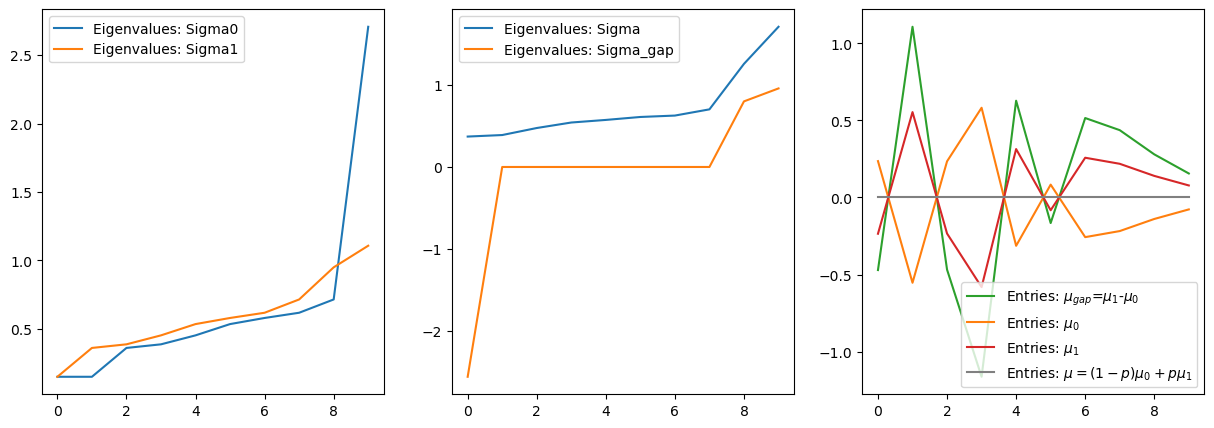

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

w0, _ = jnp.linalg.eigh(Algo.Sigma0)
w1, _ = jnp.linalg.eigh(Algo.Sigma1)
w, _ = jnp.linalg.eigh(Algo.Sigma)
wg, _ = jnp.linalg.eigh(Algo.Sigma_gap)

ax[0].plot(w0, label='Eigenvalues: Sigma0')
ax[0].plot(w1, label='Eigenvalues: Sigma1')
ax[0].legend()
ax[1].plot(w, label='Eigenvalues: Sigma')
ax[1].plot(wg,label='Eigenvalues: Sigma_gap')
ax[1].legend()
ax[2].plot(Algo.mu_gap, c='tab:green', label='Entries: $\mu_{gap}$=$\mu_1$-$\mu_0$')
ax[2].plot(Algo.mu0, c='tab:orange', label='Entries: $\mu_0$')
ax[2].plot(Algo.mu1, c='tab:red', label='Entries: $\mu_1$')
ax[2].plot(Algo.mu, c='gray', label='Entries: $\mu=(1-p)\mu_0 + p\mu_1$')
ax[2].legend()

In [76]:
unfair_pc_score = [(jnp.linalg.norm(Algo.eigvec_Sigma[:,-i-1] @ Algo.eigvec_Q_hat[:,-1:]), i) for i in range(Algo.d)]
max(unfair_pc_score, key=lambda x: x[0])
sorted(unfair_pc_score, key=lambda x: -x[0])[:12]

[(Array(0.7079348, dtype=float32), 0),
 (Array(0.70587516, dtype=float32), 1),
 (Array(0.01604094, dtype=float32), 2),
 (Array(0.01096928, dtype=float32), 7),
 (Array(0.00813683, dtype=float32), 4),
 (Array(0.00762124, dtype=float32), 9),
 (Array(0.00515282, dtype=float32), 5),
 (Array(0.00445059, dtype=float32), 8),
 (Array(0.00334978, dtype=float32), 3),
 (Array(0.00291573, dtype=float32), 6)]

In [77]:
# n_samples = 1000
# Data = [[], []]
# while len(Data[0]) < n_samples and len(Data[1]) < n_samples:
#     s, data = Algo.sample()
#     if len(Data[s]) < n_samples:
#         Data[s].append(data)

n_samples = 300
Data = [[], []]
for _ in range(n_samples):
    s, data = Algo.sample()
    Data[s].append(data)


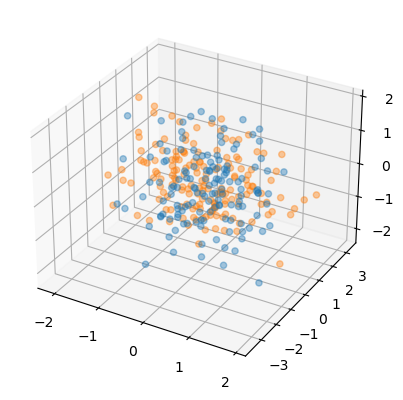

In [78]:
%matplotlib inline

plt.figure()
ax = plt.subplot(111,projection='3d')
X0,Y0,Z0 = jnp.stack(Data[0], 1)[:3]
X1,Y1,Z1 = jnp.stack(Data[1], 1)[:3]
ax.scatter(X0,Y0,Z0, alpha=0.4)
ax.scatter(X1,Y1,Z1, alpha=0.4)

# X2 = jnp.linspace(-10,10, 200)
# Y2 = 2 * X2
# Z2 = 0 * X2
# Data.append(zip(X2,Y2,Z2))
# Data[2] = list(map(jnp.stack, Data[2]))
# ax.scatter(X2,Y2,Z2)
# plt.show()

## Offline Training

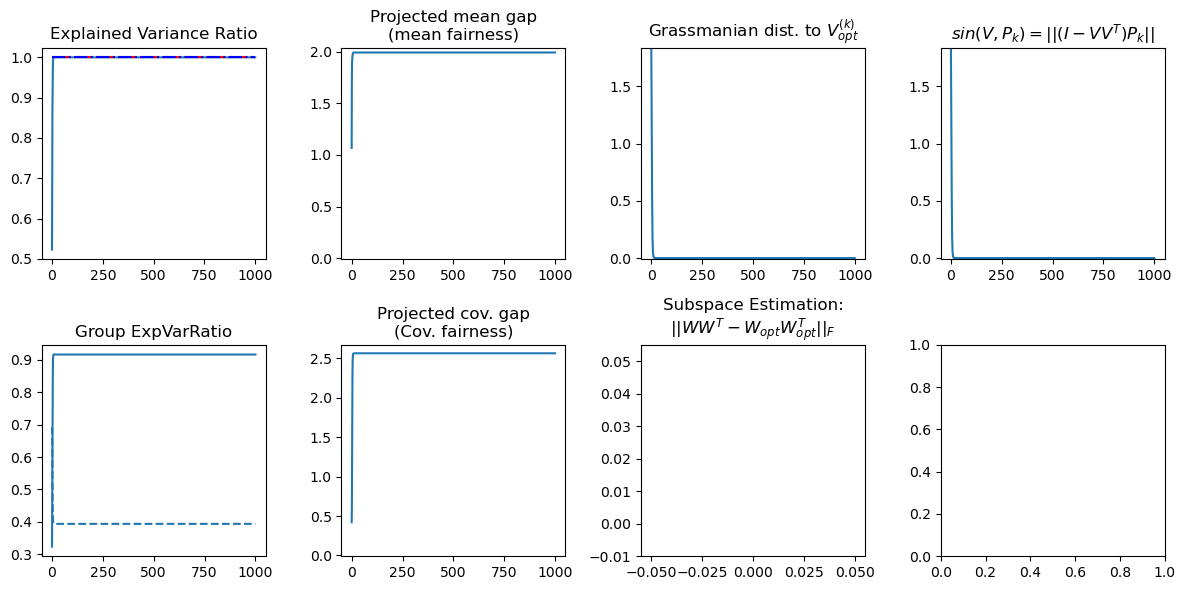

In [79]:
n_iter = 1000
Algo.offline_train(
    target_dim=2,
    rank=1,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    lr=1,
    pca_optimization='pm',
    constraint='vanilla',
    # seed=0,
)
fig, axes = Algo.plot_buffer(save=None);  # semicolon
# Algo.plot_buffer(save=None, fig=fig, axes=axes); 
# fig

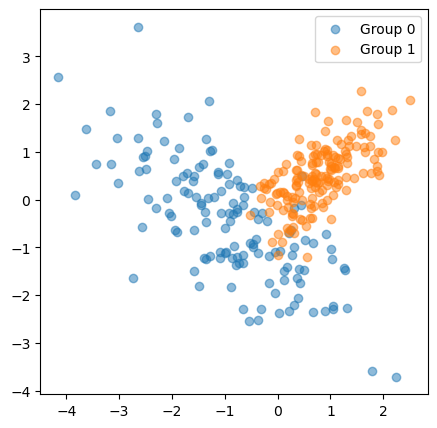

In [80]:
X_vanilla, Y_vanilla = [[],[]], [[],[]]
# X_vanilla, Y_vanilla = [[],[],[]], [[],[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_vanilla[s].append(x)
        Y_vanilla[s].append(y)

plt.figure(figsize=(5,5))
plt.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=0.5)
plt.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=0.5)
# plt.scatter(X_vanilla[2],Y_vanilla[2], label='Group 2', alpha=0.5)
plt.legend()
# plt.xlim(-5,5)
# plt.ylim(-5,5)

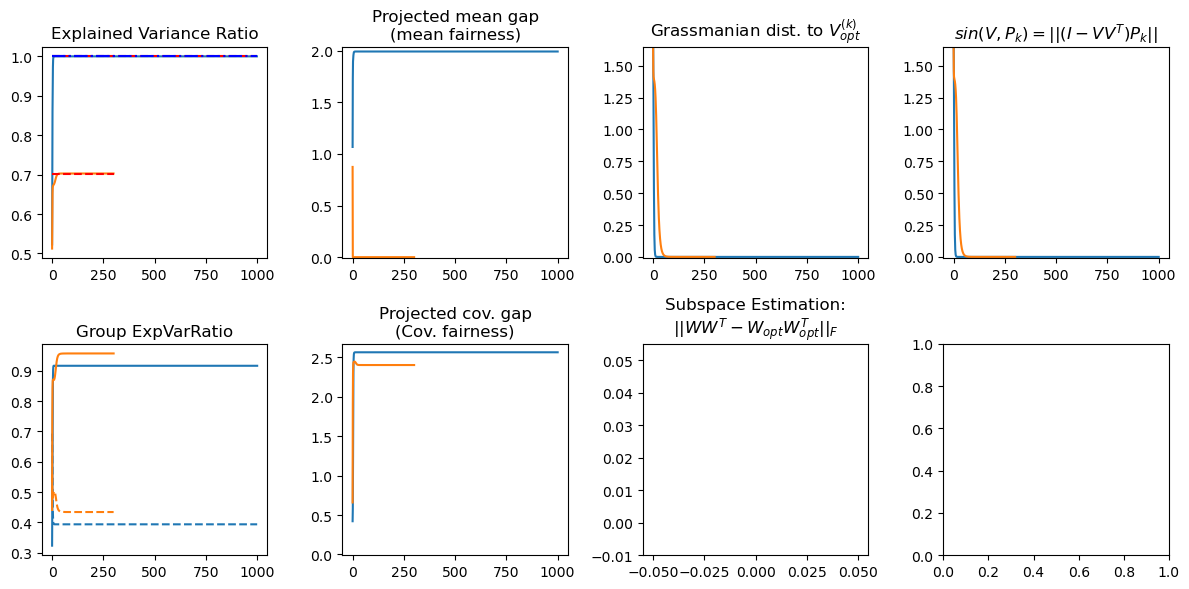

In [81]:
n_iter=300
Algo.offline_train(
    target_dim=2,
    rank=0,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    lr=1,
    pca_optimization='pm',
    constraint='mean',
    seed=0,
)
# fig, axes = Algo.plot_buffer(save=None); 
Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

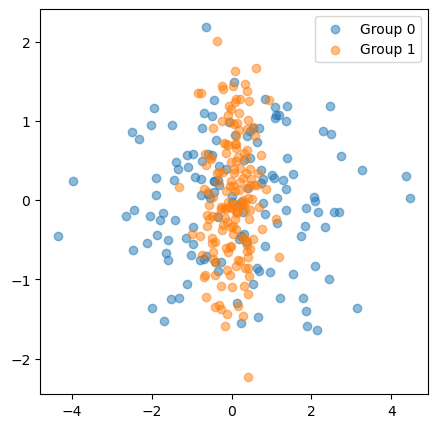

In [82]:
X_mean, Y_mean = [[],[]], [[],[]]
# X_mean, Y_mean = [[],[],[]], [[],[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_mean[s].append(x)
        Y_mean[s].append(y)

plt.figure(figsize=(5,5))
plt.scatter(X_mean[0],Y_mean[0], label='Group 0', alpha=0.5)
plt.scatter(X_mean[1],Y_mean[1], label='Group 1', alpha=0.5)
# plt.scatter(X_mean[2],Y_mean[2], label='Group 1', alpha=0.5)
plt.legend()
# plt.xlim(-5,5)
# plt.ylim(-5,5)

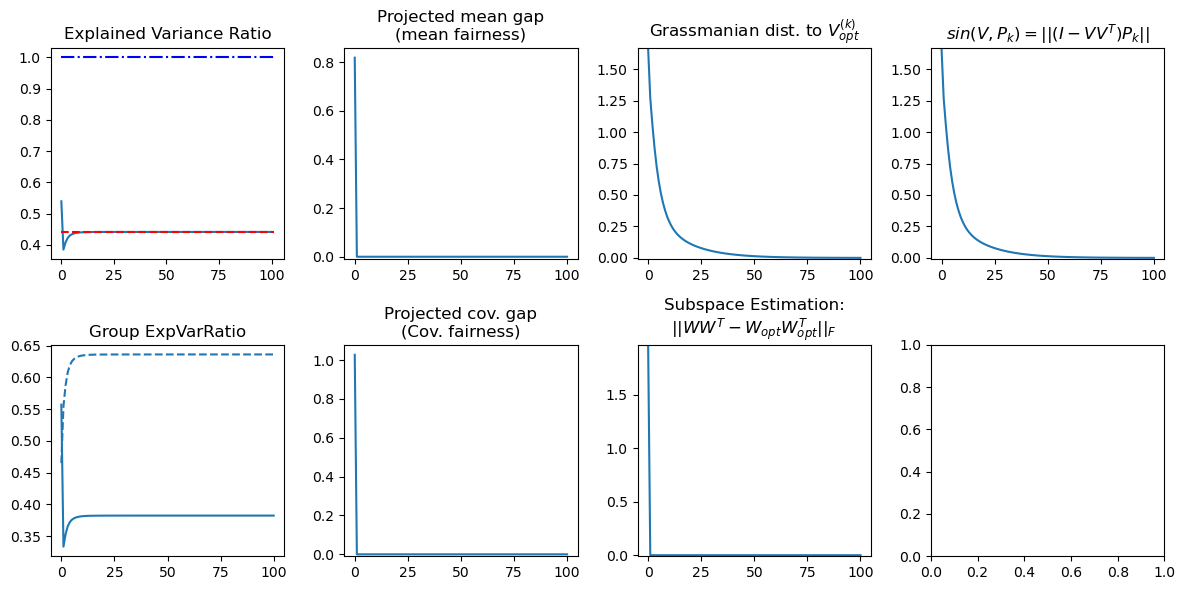

In [83]:
Algo.offline_train(
    target_dim=2,
    rank=3,
    n_iter=100,
    n_iter_inner=100,
    lr=None,
    pca_optimization='pm',
    constraint='all',
    seed=0,
)
fig, axes = Algo.plot_buffer(save=None); 
# Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

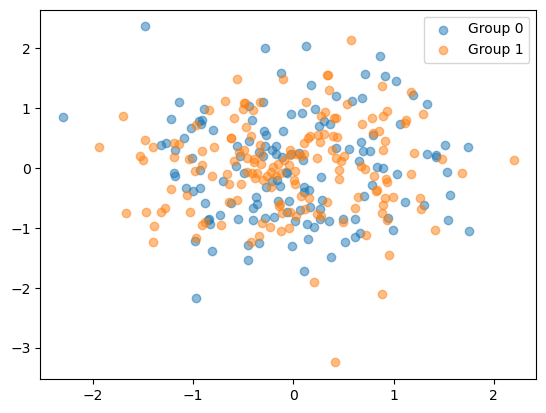

In [84]:
X_all, Y_all = [[],[]], [[],[]]
# X_all, Y_all = [[],[],[]], [[],[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_all[s].append(x)
        Y_all[s].append(y)


plt.scatter(X_all[0],Y_all[0], label='Group 0', alpha=0.5)
plt.scatter(X_all[1],Y_all[1], label='Group 1', alpha=0.5)
# plt.scatter(X_all[2],Y_all[2], label='Group 2')
plt.legend()
# plt.xlim(-5,5)
# plt.ylim(-5,5)
plt.show()

Text(0.5, 1.0, 'Mean&Cov-Fair PCA')

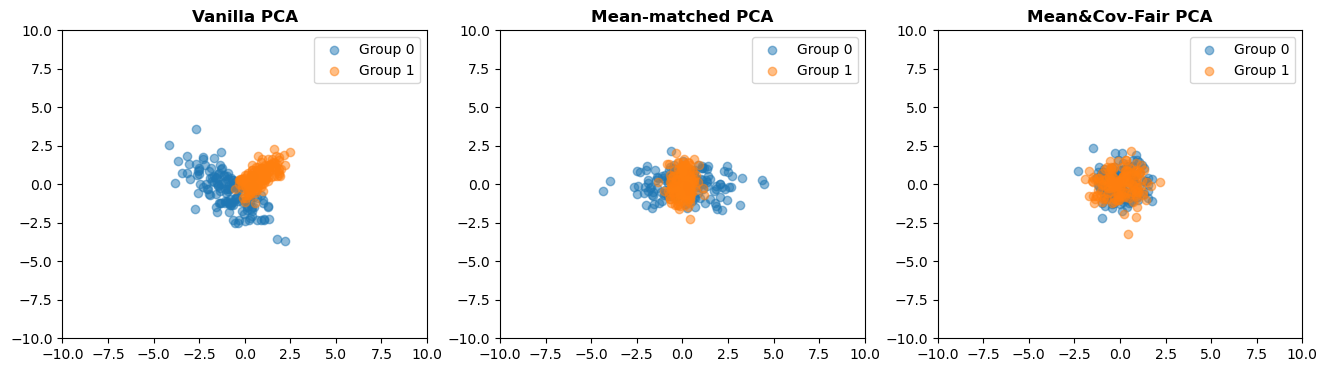

In [85]:
# Scatter plots in one figure
fig_all, axes_all = plt.subplots(1,3, figsize=(16,4))

# axes_all[0] = plt.subplot(141, projection='3d')
# ax = axes_all[0]
# X0,Y0,Z0 = zip(*Data[0])
# X1,Y1,Z1 = zip(*Data[1])
# ax.scatter(X0,Y0,Z0, label='Group 0')
# ax.scatter(X1,Y1,Z1, label='Group 1')
alpha=0.5

ax = axes_all[0]
ax.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=alpha)
ax.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title('Vanilla PCA', weight='bold')

ax = axes_all[1]
ax.scatter(X_mean[0],Y_mean[0], label='Group 0', alpha=alpha)
ax.scatter(X_mean[1],Y_mean[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title('Mean-matched PCA', weight='bold')

ax = axes_all[2]
ax.scatter(X_all[0],Y_all[0], label='Group 0', alpha=alpha)
ax.scatter(X_all[1],Y_all[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title('Mean&Cov-Fair PCA', weight='bold')

## Online - Fair PCA

  0%|          | 0/100 [00:00<?, ?it/s]

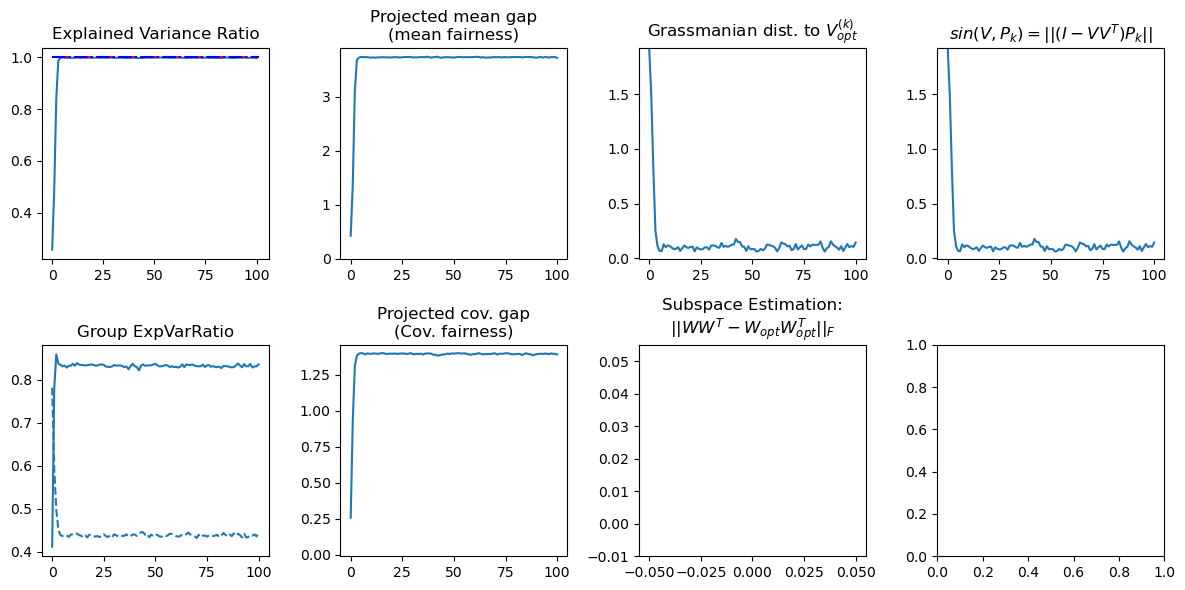

In [26]:
n_iter = 100
Algo.train(
    target_dim=2,
    rank=0,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    batch_size_subspace=None,
    batch_size_pca=1000,
    constraint='vanilla', # unfair
    subspace_optimization=None,
    pca_optimization='npm',
    lr_pca=None,
    seed=0,
    verbose=True,
    # lr_scheduler=lambda t: 0.998**(t-1)
)
fig, axes = Algo.plot_buffer(save=None);  # semicolon
# Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

In [29]:
X_vanilla, Y_vanilla = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_vanilla[s].append(x)
        Y_vanilla[s].append(y)

plt.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=0.9)
plt.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=0.9)
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)

AssertionError: Training is NOT done

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

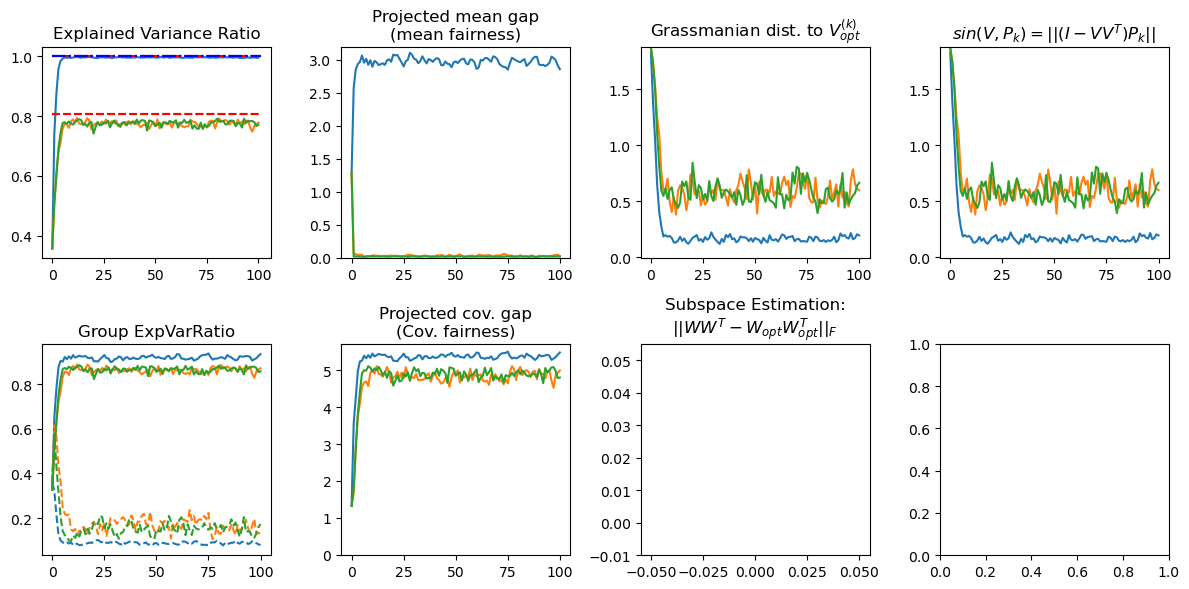

In [77]:
n_iter = 100
Algo.train(
    target_dim=2,
    rank=0,
    n_iter=n_iter,
    n_iter_inner=n_iter,
    batch_size_subspace=1000,
    batch_size_pca=1000,
    constraint='mean', # unfair
    subspace_optimization='npm',
    pca_optimization='npm',
    lr_pca=None,
    seed=0,
    verbose=True,
    # lr_scheduler=lambda t: 0.998**(t-1)
)
# fig, axes = Algo.plot_buffer(save=None);  # semicolon
Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

(-5.0, 5.0)

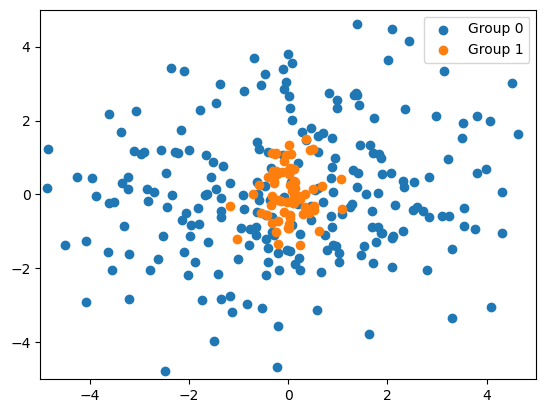

In [78]:
X_mean, Y_mean = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_mean[s].append(x)
        Y_mean[s].append(y)


plt.scatter(X_mean[0],Y_mean[0], label='Group 0')
plt.scatter(X_mean[1],Y_mean[1], label='Group 1')
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

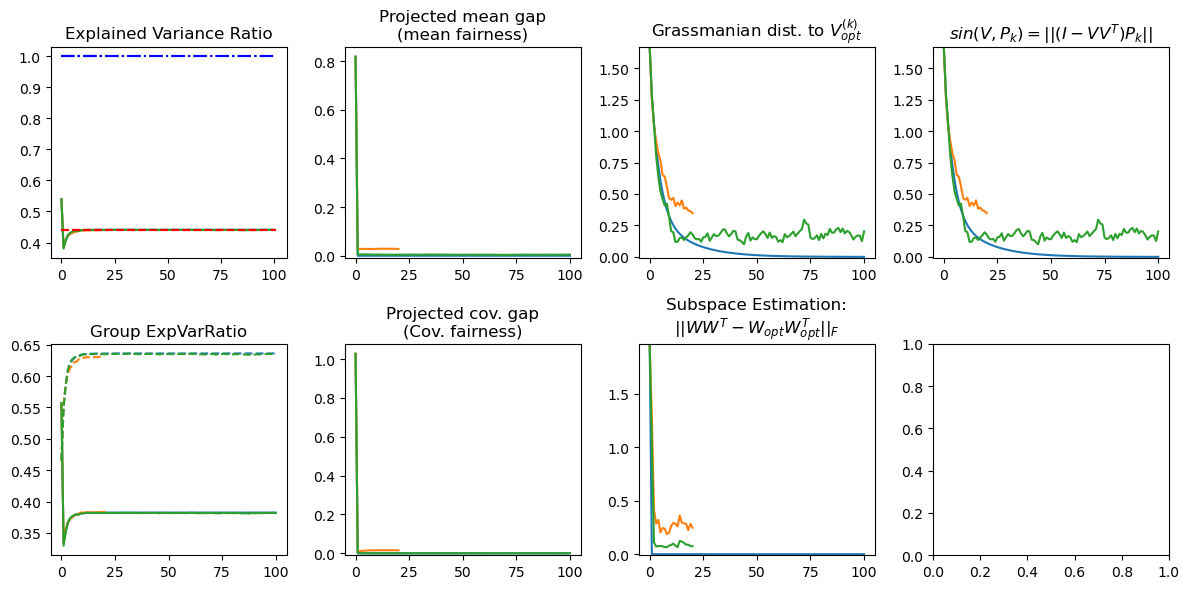

In [91]:
Algo.train(
    target_dim=2,
    rank=3,
    n_iter=100,
    n_iter_inner=20,
    batch_size_subspace=10000,
    batch_size_pca=1000,
    constraint='all',
    subspace_optimization='npm',
    pca_optimization='npm',
    lr_pca=None,
    seed=0,
    verbose=True,
    # lr_scheduler=lambda t: 0.998**(t-1)
    use_true_N=False
)
# fig, axes = Algo.plot_buffer(save=None);  # semicolon
Algo.plot_buffer(save=None, fig=fig, axes=axes); fig

In [ ]:
jnp.linalg.norm(Algo.true_N.T @ Algo.V, 2)

Array(0.14655572, dtype=float32)

In [36]:
exp_var_opt, _ = Algo.get_ground_truth(2, 4)
Algo.buffer.explained_variance_ratio[-1], Algo.exp_var_gt/Algo.total_var

(Array(0.5753768, dtype=float32), Array(0.5801214, dtype=float32))

In [9]:
X_all, Y_all = [[],[]], [[],[]]
for s in range(2):
    for data in Data[s]:
        x, y = Algo.transform_low_dimension(data)
        X_all[s].append(x)
        Y_all[s].append(y)


plt.scatter(X_all[0],Y_all[0], label='Group 0')
plt.scatter(X_all[1],Y_all[1], label='Group 1')
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)

AssertionError: Training is NOT done

Text(0.5, 1.0, 'Fair PCA')

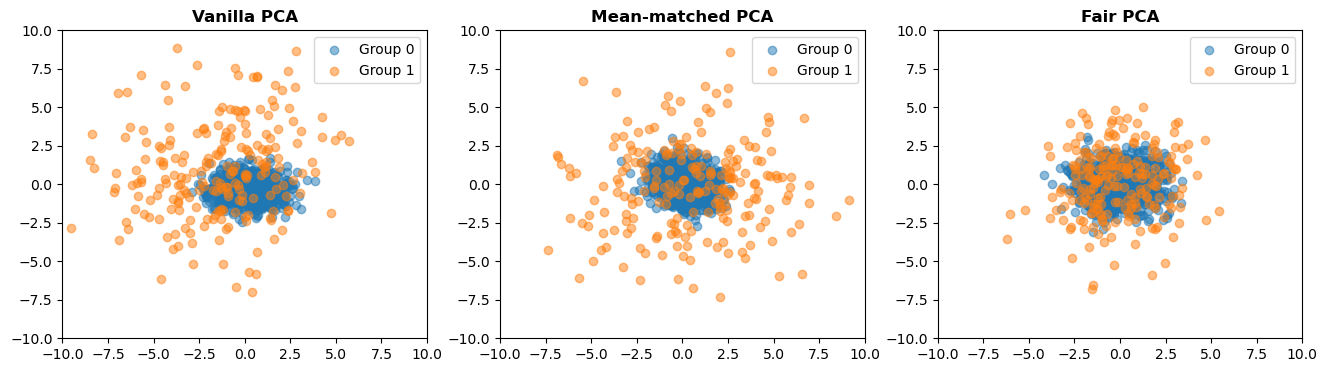

In [167]:
# Scatter plots in one figure
fig_all, axes_all = plt.subplots(1,3, figsize=(16,4))

# axes_all[0] = plt.subplot(141, projection='3d')
# ax = axes_all[0]
# X0,Y0,Z0 = zip(*Data[0])
# X1,Y1,Z1 = zip(*Data[1])
# ax.scatter(X0,Y0,Z0, label='Group 0')
# ax.scatter(X1,Y1,Z1, label='Group 1')
alpha=0.5

ax = axes_all[0]
ax.scatter(X_vanilla[0],Y_vanilla[0], label='Group 0', alpha=alpha)
ax.scatter(X_vanilla[1],Y_vanilla[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title('Vanilla PCA', weight='bold')

ax = axes_all[1]
ax.scatter(X_mean[0],Y_mean[0], label='Group 0', alpha=alpha)
ax.scatter(X_mean[1],Y_mean[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title('Mean-matched PCA', weight='bold')

ax = axes_all[2]
ax.scatter(X_all[0],Y_all[0], label='Group 0', alpha=alpha)
ax.scatter(X_all[1],Y_all[1], label='Group 1', alpha=alpha)
ax.legend()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_title('Fair PCA', weight='bold')